# **Лабораторная работа №6 по вычислительной математикe.**

## Работу выполнил: Шурыгин Антон, Б01 - 909.

### **X.9.13**

#### Численность двух популяций заивисит от взаимодействия между ними и двух медленно меняющихся генетических признаков:

$$
\dot x = x(2\alpha_1 + 0,5x - \alpha_1^{2}\alpha_2^{-2}y)
\\
\dot y = y(2\alpha_2 + 0,5y - \alpha_1^{-2}\alpha_2^{2}x)
\\
\dot \alpha_1 = \varepsilon(2 - 2 \alpha_1 \alpha_2^{-2}y)
\\
\dot \alpha_2 = \varepsilon(2 - 2 \alpha_1^{-2} \alpha_2x)
\\
$$

#### Причем параметры задачи таковы, что:
$$
\varepsilon \leq 0.01, \:\:\: 0 \leq x_0 \leq 40, \:\:\: 0 \leq y_0 \leq 40, \:\:\: \alpha_{10} \ll 1, \:\:\:, \alpha_{20} = 10
$$

In [202]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from sympy import Matrix

#### Рассмотрим задачу Коши для жесткой системы обыкновенной дифференциальных уравнений:

$$
u' = f(u)
\\
u(t_0) = u_0
$$

где u, f(u) - вещественные четырехмерные (в общем случае n-мерные) вектор-функции

#### Рассмотрим численную формулу вида:

$$
u_{n+1} = u_n + p_1 k_1 + p_2 k_2 + p_3 k_3
\\
D_n k_1 = h f(u_n)
\\
D_n k_2 = h f(u_n + b_{21} k_1)
\\
D_n k_3 = h f(u_n + b_{31} k_1 + b_{32} k_2)
$$

#### Определим константы отвечающие начальным условиям и трехстадийному методу Розенброка

In [228]:
eps = 0.01

x0 = 0.1
y0 = 0.1
a10 = 0.01
a20 = 10

p1 = 0.43687
p2 = 0.47824
p3 = 0.08589
a = 0.43687
b21 = 0.43687
b31 = 0.43687
b32 = -2.11605

Tk = 2000

h = 0.001

In [219]:
x = sp.Symbol('x')
y = sp.Symbol('y')
a1 = sp.Symbol('a1')
a2 = sp.Symbol('a2') 

diff_eqs1 = {"f1" : x*(2*a1 - 0.5*x - y * (a1 ** 2) * (a2 ** (-2))), 
            "f2" : x*(2*a2 - 0.5*y - x * (a2 ** 2) * (a1 ** (-2))),
            "f3" : eps*(2 - 2 * y * a1 * a2 ** (-2)),
            "f4" : eps*(2 - 2 * x * a2 * a1 ** (-2))
            }

X1 = Matrix([diff_eqs1["f1"], diff_eqs1["f2"], diff_eqs1["f3"], diff_eqs1["f4"]])
Y1 = Matrix([x, y, a1, a2])

J1 = X1.jacobian(Y1)
J1

Matrix([
[ -a1**2*y/a2**2 + 2*a1 - 1.0*x, -a1**2*x/a2**2, x*(-2*a1*y/a2**2 + 2),    2*a1**2*x*y/a2**3],
[2*a2 - 0.5*y - 2*a2**2*x/a1**2,         -0.5*x,    2*a2**2*x**2/a1**3, x*(2 - 2*a2*x/a1**2)],
[                             0, -0.02*a1/a2**2,         -0.02*y/a2**2,      0.04*a1*y/a2**3],
[                -0.02*a2/a1**2,              0,       0.04*a2*x/a1**3,        -0.02*x/a1**2]])

In [220]:
def jacbn(j_matr, u_k):
    jacob = np.array(j_matr.subs({x : u_k[0], y : u_k[1], a1 : u_k[2], a2 : u_k[3]}))
    
    return np.array([   [float(jacob[0][0]),
                        float(jacob[0][1]),
                        float(jacob[0][2]),
                        float(jacob[0][3])],

                        [float(jacob[1][0]),
                        float(jacob[1][1]),
                        float(jacob[1][2]),
                        float(jacob[1][3])],

                        [float(jacob[2][0]),
                        float(jacob[2][1]),
                        float(jacob[2][2]),
                        float(jacob[2][3])],

                        [float(jacob[3][0]),
                        float(jacob[3][1]),
                        float(jacob[3][2]),
                        float(jacob[3][3])]
                    ])


def f(diff_eqs, u_k):
    return np.array([float(diff_eqs["f1"].subs({x : u_k[0], y : u_k[1], a1 : u_k[2], a2 : u_k[3]})),
                     float(diff_eqs["f2"].subs({x : u_k[0], y : u_k[1], a1 : u_k[2], a2 : u_k[3]})),
                     float(diff_eqs["f3"].subs({x : u_k[0], y : u_k[1], a1 : u_k[2], a2 : u_k[3]})),
                     float(diff_eqs["f4"].subs({x : u_k[0], y : u_k[1], a1 : u_k[2], a2 : u_k[3]}))])


#### Решаем систему уравнений

In [225]:
def Rosenbrock3(diff_eqs, j_matr, u0, step):

    t_arr = np.linspace(0, Tk, int(Tk / step))
    sol = []
    u_n = u0

    for t_n in t_arr:
        Dn = np.eye(4) + a * step * jacbn(j_matr, u_n)

        d1 = step*f(diff_eqs, u_n)
        k1 = np.linalg.solve(Dn, d1)

        d2 = step*f(diff_eqs, u_n + b21 * k1)
        k2 = np.linalg.solve(Dn, d2)

        d3 = step*f(diff_eqs, u_n + b31 * k1 + b32 * k2)
        k3 = np.linalg.solve(Dn, d3)

        u_n_1 = u_n + p1 * k1 + p2 * k2 + p3 * k3
        sol.append(u_n_1)

        u_n = u_n_1

    print(f"РЕЗУЛЬТАТ ИНТЕГРИРОВАНИЯ")
    print(np.array(sol).T)

    return np.array(sol).T, t_arr


#### Визуализируем результат

In [226]:
def genetic_model_plot(u, t_arr):
    
    plt.figure(figsize=[16, 8])

    plt.plot(t_arr, u[0], color='b', label='x')
    plt.plot(t_arr, u[1], color='r', linestyle='--', label='y')
    plt.plot(t_arr, u[2], color='c', linestyle=':', label='a1')
    plt.plot(t_arr, u[3], color='g', linestyle='-.', label='a2')

    plt.title(f"Решение для экогенетической модели")

    plt.xlabel("t")
    plt.ylabel("u")

    plt.legend()
    plt.show()

Начальный вектор [0.1, 0.1, 0.01, 10]
Значение Tk=20
Шаг=0.001
РЕЗУЛЬТАТ ИНТЕГРИРОВАНИЯ
[[ 9.99969950e-02  9.99939954e-02  9.99910011e-02 ...             nan
              nan             nan]
 [-1.00747792e+01 -1.98019607e+01 -2.91028059e+01 ...             nan
              nan             nan]
 [ 1.00200126e-02  1.00400461e-02  1.00601014e-02 ...             nan
              nan             nan]
 [ 9.79801802e+00  9.60091804e+00  9.40856523e+00 ...             nan
              nan             nan]]


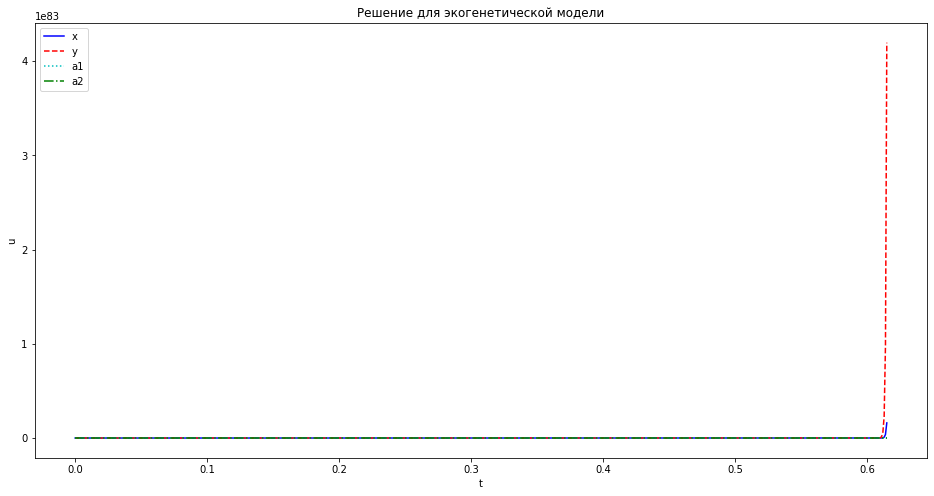

In [227]:
cur_step = 0.001
u0 = [x0, y0, a10, a20]
print(f"Начальный вектор {u0}")
print(f"Значение Tk={Tk}")
print(f"Шаг={cur_step}")

sol, t_arr = Rosenbrock3(diff_eqs1, J1, u0, step=cur_step)
genetic_model_plot(sol, t_arr)

#### Численность двух популяций заивисит от взаимодействия между ними и двух медленно меняющихся генетических признаков:

$$
\dot x = x(2\alpha_1 - 0,5x - \alpha_1^{3}\alpha_2^{-3}y)
\\
\dot y = y(2\alpha_2 - 0,5y - \alpha_1^{-3}\alpha_2^{3}x)
\\
\dot \alpha_1 = \varepsilon(2 - 3 \alpha_1^{2} \alpha_2^{-3}y)
\\
\dot \alpha_2 = \varepsilon(2 - 2 \alpha_1^{-3} \alpha_2^{2} x)
\\
$$

#### Причем параметры задачи таковы, что:
$$
\varepsilon \leq 0.01, \:\:\: 0 \leq x_0 \leq 40, \:\:\: 0 \leq y_0 \leq 40, \:\:\: \alpha_{10} \ll 1, \:\:\:, \alpha_{20} = 10

In [ ]:
diff_eqs2 = {"f1" : x*(2*a1 - 0.5*x - y * (a1 ** 3) * (a2 ** (-3))), 
            "f2" : x*(2*a2 - 0.5*y - x * (a2 ** 3) * (a1 ** (-3))),
            "f3" : eps*(2 - 3 * y * a1 ** (2) * a2 ** (-3)),
            "f4" : eps*(2 - 3 * x * a2 ** (2) * a1 ** (-3))
            }

X2 = Matrix([diff_eqs1["f1"], diff_eqs1["f2"], diff_eqs1["f3"], diff_eqs1["f4"]])
Y2 = Matrix([x, y, a1, a2])

J2 = X2.jacobian(Y2)
J2

Matrix([
[ -a1**2*y/a2**2 + 2*a1 - 1.0*x, -a1**2*x/a2**2, x*(-2*a1*y/a2**2 + 2),    2*a1**2*x*y/a2**3],
[2*a2 - 0.5*y - 2*a2**2*x/a1**2,         -0.5*x,    2*a2**2*x**2/a1**3, x*(2 - 2*a2*x/a1**2)],
[                             0, -0.02*a1/a2**2,         -0.02*y/a2**2,      0.04*a1*y/a2**3],
[                -0.02*a2/a1**2,              0,       0.04*a2*x/a1**3,        -0.02*x/a1**2]])

In [229]:
cur_step = 0.1
u0 = [x0, y0, a10, a20]
print(f"Начальный вектор {u0}")
print(f"Значение Tk={Tk}")
print(f"Шаг={cur_step}")

sol, t_arr = Rosenbrock3(diff_eqs2, J2, u0, step=cur_step)
genetic_model_plot(sol, t_arr)

Начальный вектор [0.1, 0.1, 0.01, 10]
Значение Tk=2000
Шаг=0.1
